In [51]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
from itertools import combinations
import joblib
import warnings

In [ ]:
class MLModelTrainer:
    def __init__(self, test_size=0.8, random_state=1):
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.metrics = {}
        self.models = {} 
        self.y_preds = {}

    def load_data(self, data_path):
        # Load data from a CSV file
        # Check the file extension to determine the appropriate reading method
        if data_path.endswith('.parquet'):
            self.data = pd.read_parquet(data_path)
        elif data_path.endswith('.csv'):
            self.data = pd.read_csv(data_path)
        else:
            raise ValueError("Unsupported file format. Please provide a .csv or .parquet file.")

    def data_split(self, cols_drop, tgt_col=["price actual"]):
        # Split and scale the data
        len_data = math.floor(len(self.data) * self.test_size)
        self.df_train = self.data[:len_data]
        self.df_val = self.data[len_data:]

        cols_drop = cols_drop + tgt_col

        # Create the tranining and validation dataset
        self.X_train = self.df_train.drop(columns=cols_drop)
        self.X_val = self.df_val.drop(columns=cols_drop)
        self.y_train = self.df_train[tgt_col]
        self.y_val = self.df_val[tgt_col]

        # One-hot encode categorical variables
        self.X_train = pd.get_dummies(self.X_train,drop_first=True)
        self.X_val = pd.get_dummies(self.X_val,drop_first=True)
        self.X_val = self.X_val.reindex(columns=self.X_train.columns, fill_value=False)
        
        #print(self.X_train.info())
        # Separate numeric and boolean columns for training data
        numeric_cols_train = self.X_train.select_dtypes(include=['float64', 'int64']).columns
        boolean_cols_train = self.X_train.select_dtypes(include=['bool']).columns

        # Initialize the StandardScaler
        self.scaler = StandardScaler()

        # Fit and transform the numeric data
        scaled_numeric_train = self.scaler.fit_transform(self.X_train[numeric_cols_train])

        # Create a DataFrame with the scaled numeric data
        scaled_numeric_train_df = pd.DataFrame(scaled_numeric_train, columns=numeric_cols_train)

        # Combine the scaled numeric DataFrame with the original boolean DataFrame
        self.X_train = pd.concat([scaled_numeric_train_df, self.X_train[boolean_cols_train].reset_index(drop=True)], axis=1)

        # For validation data, scale numeric columns
        numeric_cols_val = self.X_val.select_dtypes(include=['float64', 'int64']).columns
        scaled_numeric_val = self.scaler.transform(self.X_val[numeric_cols_val])

        # Create a DataFrame with the scaled numeric data for validation
        scaled_numeric_val_df = pd.DataFrame(scaled_numeric_val, columns=numeric_cols_val)

        # Combine the scaled numeric DataFrame with the original boolean DataFrame for validation
        self.X_val = pd.concat([scaled_numeric_val_df, self.X_val[boolean_cols_train].reset_index(drop=True)], axis=1)

        # Prepare the full dataset for return
        X = pd.get_dummies(self.data.drop(columns=cols_drop),drop_first=True)
        numeric_cols_full = X.select_dtypes(include=['float64', 'int64']).columns
        boolean_cols_full = X.select_dtypes(include=['bool']).columns

        # Scale the numeric columns of the full dataset
        X_scaled = self.scaler.transform(X[numeric_cols_full])
        X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols_full)

        # Combine with the original boolean columns
        self.X = pd.concat([X_scaled_df, X[boolean_cols_full].reset_index(drop=True)], axis=1)

 
        self.y = self.data[tgt_col]

   
    def train(self, models):
        # Fit multiple models based on dictionary input
        # Models is a dictionary made up model names as keys and values as model initializer
        for model_name, model in models.items():
            model.fit(self.X_train, self.y_train)
            self.models[model_name] = model 
            print(f"{model_name} finished training")

    def evaluate(self):
        # Based of fitted models, evaluate and store metrics as a dictionary based on model name
        metrics_results = {}
        for model_name, model in self.models.items():
            # Make predictions
            y_pred = model.predict(self.X_val)
            
            if self.X_val is None or self.y_val is None:
                raise ValueError("Validation data is not available")
            # Calculate metrics
            mae = mean_absolute_error(self.y_val, y_pred)
            mse = mean_squared_error(self.y_val, y_pred)
            rmse = root_mean_squared_error(self.y_val, y_pred)
            r2 = r2_score(self.y_val, y_pred)
            # Store y_pred
            self.y_preds[model_name] = y_pred
            # Store metrics
            metrics_results[model_name] = {
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                "r2": r2
            }
        self.metrics = metrics_results
        return metrics_results

    def print_metrics(self):
        # Print the metrics
        
        #Checks if self.models exist
        if not self.models:
            raise ValueError("Train the models")
        #Evalutaes if no metrics exist
        if not self.metrics or (len(self.metrics) != len(self.models)):
            self.evaluate()
            
        #Print the metrics
        for model_name, metrics in self.metrics.items():
            print(f"Metrics for {model_name} model:")
            for metric_name, value in metrics.items():
                print(f"  {metric_name}: {value:.2f}")
            print() 

    def grid_search_train(self, model_and_params, n_splits=5):
        # Performs a grid search with time series cross-validation based on input models
        # model_and_params: dict, where keys are model names and values are tuples of (model, param_grid).
        tscv = TimeSeriesSplit(n_splits=n_splits)

        for model_name, (model, param_grid) in model_and_params.items():
            print(f"\nRunning grid search for {model_name} using TimeSeriesSplit...")
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=tscv,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )
            grid_search.fit(self.X_train, self.y_train.values.ravel())
            self.models[model_name] = grid_search.best_estimator_
            print(f"Best parameters for {model_name}: {grid_search.best_params_}")

In [53]:
def calculate_weekly_averages(x, y):
    x = x.ravel()
    try:
        y = y.values
    except:
        pass
    y = y.ravel()
    df = pd.DataFrame({'date': x, 'value': y})
    df.set_index('date', inplace=True)
    weekly_avg = df.resample('W').mean()
    return weekly_avg.index, weekly_avg['value']

def plot_model_preds(data, model_name):
    if model_name not in data.models:
        raise ValueError(f"Model '{model_name}' not found in trained models.")


    y_pred = data.y_preds[model_name]



    x_train_weekly, y_train_weekly = calculate_weekly_averages(data.df_train["time"], data.y_train)
    x_test_weekly, y_test_weekly = calculate_weekly_averages(data.df_val["time"], data.y_val)
    x_pred_weekly, y_pred_weekly = calculate_weekly_averages(data.df_val["time"], y_pred)

    plt.figure(figsize=(12, 6))
    plt.plot(x_train_weekly, y_train_weekly, label='Weekly Avg Train', color='blue')
    plt.plot(x_test_weekly, y_test_weekly, label='Weekly Avg Test', color='orange')
    plt.plot(x_pred_weekly, y_pred_weekly, label='Predictions', color='green', linestyle='--')

    plt.title(f'{model_name} Weekly Averages and Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

In [54]:

def df_train_val_split(df, split_index = 0.8):
    split_index = int(len(df)*.8)

    df_train = df.iloc[:split_index,:]
    df_val = df.iloc[split_index:,:]
    return df_train, df_val

def train_data_split(df, train_cols_drop =["time","price actual"], predictor = ["price actual"]):

    
    x, y = df.drop(columns = train_cols_drop), df[predictor]

    return x, y


def get_metrics(model, X_test,y_test):

    #Prediction
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mse ** 0.5  # Root Mean Squared Error
    r2 = r2_score(y_test, y_pred)

    metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R^2': r2,
    }
    return metrics, y_pred

def train_model(model, X_train, X_val, y_train, y_val):
    #Split data and train model
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_val = pd.get_dummies(X_val, drop_first=True)
    X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
    model.fit(X_train,y_train)
    metrics, _ = get_metrics(model, X_val,y_val)
    return metrics



def create_time_period_features(step, df):
    #Create features related to time and splits the training
    warnings.filterwarnings("ignore")
    time_feat_df = create_time_features(df, create_time_period_feature=True,step=step)
    

    #merged_time_df = time_feat_df.merge(df[['time', 'price actual']], how='outer', on='time')

    time_period_df_train, time_period_df_val = df_train_val_split(time_feat_df)
    time_period_X_train, time_period_y_train = train_data_split(time_period_df_train)
    time_period_X_val, time_period_y_val = train_data_split(time_period_df_val)

    return train_model(LinearRegression(), time_period_X_train, time_period_X_val, time_period_y_train, time_period_y_val)

def create_time_features(df, create_time_period_feature = False, step = 3):
    #Creates time related features of month, day, hour
    time_feat_df = pd.DataFrame()
    time_feat_df = df[["time","price actual"]]

    time_feat_df["month"] = time_feat_df['time'].dt.month_name()
    time_feat_df["day"] = time_feat_df['time'].dt.day_name()
    time_feat_df["hour"] = time_feat_df["time"].dt.hour.astype('category')
    #Creates stepped features based on hour
    #using pd.getdummies creates 23 additional features, whereas hour features could be captured via a period
    if create_time_period_feature:
        for i in range(step, 24, step):
            time_feat_df[f"is_btwn_{i}_and_{i+step}"] = time_feat_df["hour"].isin(range(i, i + step)).astype(bool)

        time_feat_df.drop(columns=["hour"],inplace=True)
    
    return time_feat_df



In [55]:
#Import data exported after data exploration
df = pd.read_csv(r"engineered_data\transformed_data_first_rev.csv")
df["time"] = pd.to_datetime(df["time"], utc = True)


In [56]:
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,temp_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,rain_3h_Seville,clouds_all_Seville,weather_id_Seville,temp_diff_Seville
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,800.0,0.0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,800.0,0.0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,800.0,0.0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,800.0,0.0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,800.0,0.0


#Create time related features

In [57]:
feature_comp_1_hr = create_time_period_features(1, df)
feature_comp_3_hr = create_time_period_features(3, df)
feature_comp_6_hr = create_time_period_features(6, df)

In [58]:
print(f'The MSE when hour for 1-hour features is included in training is {feature_comp_1_hr["MSE"]:.2f}')
print(f'The MSE when hour for three-hour features is included in training is {feature_comp_3_hr["MSE"]:.2f}')
print(f'The MSE when hour for six-hour features is included in training is {feature_comp_6_hr["MSE"]:.2f}')


The MSE when hour for 1-hour features is included in training is 166.23
The MSE when hour for three-hour features is included in training is 168.15
The MSE when hour for six-hour features is included in training is 171.18


There is little difference in MSE if there are 1, 3, or 6 hour gaps for time features. To maximize information captured and minimize features, the 6 hour gap will be used.

In [59]:
# Create time features
lag_ma_feats = create_time_features(df)
lag_ma_feats["year"] = lag_ma_feats["time"].dt.year
lag_ma_feats["week"] = lag_ma_feats["time"].dt.isocalendar().week
lag_ma_feats.set_index("time", inplace=True)

# Compute weekly average and merge with previous years for comparison
weekly_avg_last_year = lag_ma_feats.groupby(["year", "week"])["price actual"].mean().reset_index()
weekly_avg_last_year["last_year_weekly_mean_price"] = weekly_avg_last_year.groupby("week")["price actual"].shift(1)
weekly_avg_last_year["last_year_weekly_mean_price"].fillna(weekly_avg_last_year.groupby("week")["last_year_weekly_mean_price"].transform("mean"), inplace=True)

# Create lagged features
for lag in [24, 24*7]: 
    lag_ma_feats[f"prev_{'day' if lag == 24 else 'week'}_price"] = lag_ma_feats["price actual"].shift(lag)
    lag_ma_feats[f"prev_{'day' if lag == 24 else 'week'}_price"].fillna(lag_ma_feats["prev_day_price"].mean(), inplace=True)

# Create moving averages
for period in [1, 3, 7, 14, 30, 90]:
    lag_ma_feats[f"{period}_day_ma"] = lag_ma_feats["price actual"].rolling(f"{period}D", min_periods=1).mean()

lag_ma_feats = lag_ma_feats.reset_index().merge(weekly_avg_last_year.drop(columns="price actual"), on=["year", "week"], how="outer")
lag_ma_feats.drop(columns=['month', 'day','hour','year', 'week'], inplace=True)



Time, lag, and moving average features are created to help the models to identify seasonality and trends

In [60]:
lag_ma_feats.drop(columns="price actual",inplace=True)

In [61]:
time_best_feat = create_time_features(df, create_time_period_feature=True,step = 6).drop(columns="price actual")
lag_ma_best_features = lag_ma_feats
merged_time_lag_ma_feat = pd.merge(time_best_feat,lag_ma_best_features,on="time",how="inner")

In [62]:
ml_data = MLModelTrainer()
ml_data.load_data(r"engineered_data\transformed_data_first_rev.csv") 
ml_data.data["time"] = pd.to_datetime(ml_data.data["time"],utc = True)

In [63]:
ml_data.data = ml_data.data.merge(merged_time_lag_ma_feat,on="time",how="inner")

In [64]:
#Price takes a quadratic trend
ml_data.data.reset_index(inplace=True)
ml_data.data.rename(columns={"index":"t"},inplace=True)
ml_data.data["t^2"] = ml_data.data["t"]**2

In [65]:
#Split the data
ml_data.data_split(["time"])
X, y = ml_data.X, ml_data.y

print(ml_data.X_train.shape)
print(ml_data.X_val.shape)
print(ml_data.y_train.shape)
print(ml_data.y_val.shape)

(28051, 104)
(7013, 104)
(28051, 1)
(7013, 1)


In [66]:

print(ml_data.df_train.shape)

(28051, 91)


Dimensionality of the dataset is very large. To keep model training time manageable and efficient dimensionality reduction will be performed via PCA.


In [67]:
#train a linear regression model on pre-pca data
models = {
    "Linear": LinearRegression()
}
ml_data.train(models)

Linear finished training


In [68]:
ml_data.print_metrics()

Metrics for Linear model:
  MAE: 3.39
  MSE: 20.20
  RMSE: 4.49
  r2: 0.85



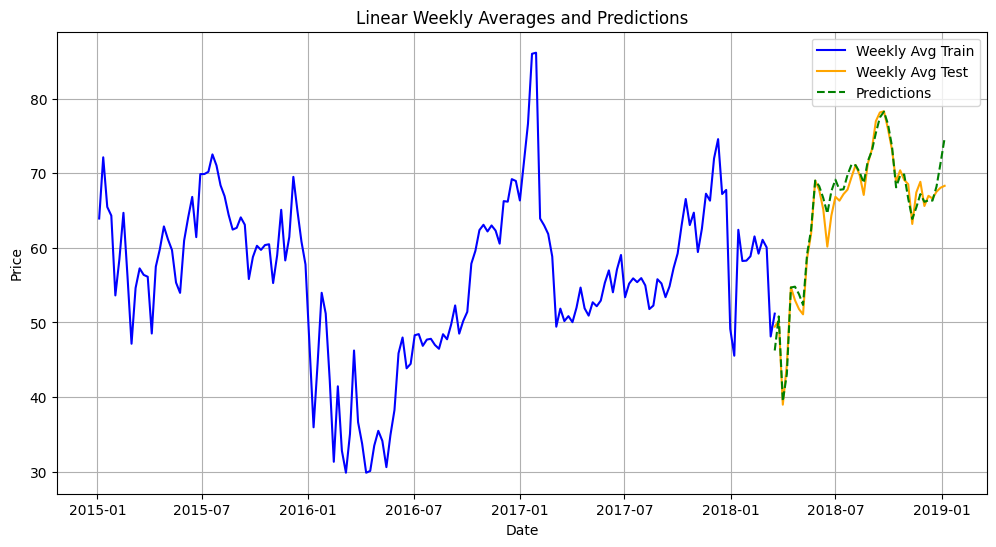

In [69]:
plot_model_preds(ml_data,"Linear")

PCA will be used to reduced dimensionality while capturing 95% of the data

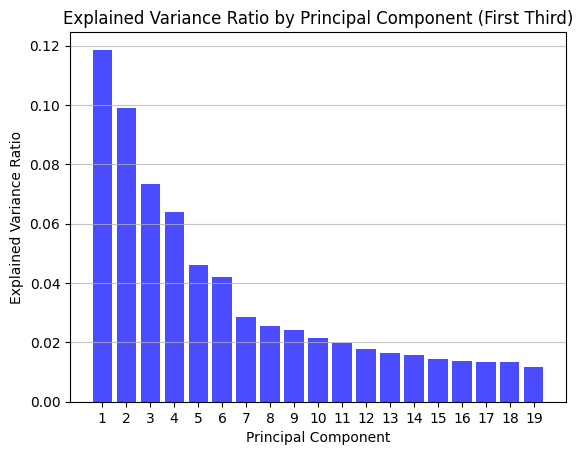

In [70]:
pca = PCA(0.95)
X_pca = pca.fit_transform(X)

# Get the explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Display a third of the PCA components
num_components_to_display = len(explained_variance_ratios) // 3

# Create a bar graph for the first half of the principal components
components = range(1, num_components_to_display + 1) 

plt.bar(components, explained_variance_ratios[:num_components_to_display], alpha=0.7, color='blue')
plt.title('Explained Variance Ratio by Principal Component (First Third)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(components)  
plt.grid(axis='y', alpha=0.75)
plt.show()


In [71]:
print(X.shape)
print(X_pca.shape)

(35064, 104)
(35064, 59)


In [72]:
# Ready the pca dataset for linear regression training
pca_data = MLModelTrainer()
pca_data.df_train = ml_data.df_train.copy()
pca_data.df_val = ml_data.df_val.copy()
pca_data.y = ml_data.y.copy()

In [73]:
# Split the dataset based on how its described in MLModelTrainer
len_data = math.floor(len(X_pca) * 0.8)
pca_data.X = X_pca
pca_data.X_train = X_pca[:len_data]
pca_data.X_val = X_pca[len_data:]
pca_data.y_train = y[:len_data]
pca_data.y_val = y[len_data:]

In [74]:
print(pca_data.X_train.shape)
print(pca_data.X_val.shape)
print(pca_data.y_train.shape)
print(pca_data.y_val.shape)

(28051, 59)
(7013, 59)
(28051, 1)
(7013, 1)


In [75]:
# Defined what model is wanted to be used for training and fit it
models = {
    "Linear": LinearRegression()
}
pca_data.train(models)

Linear finished training


In [76]:
pca_data.print_metrics()

Metrics for Linear model:
  MAE: 3.75
  MSE: 26.17
  RMSE: 5.12
  r2: 0.80



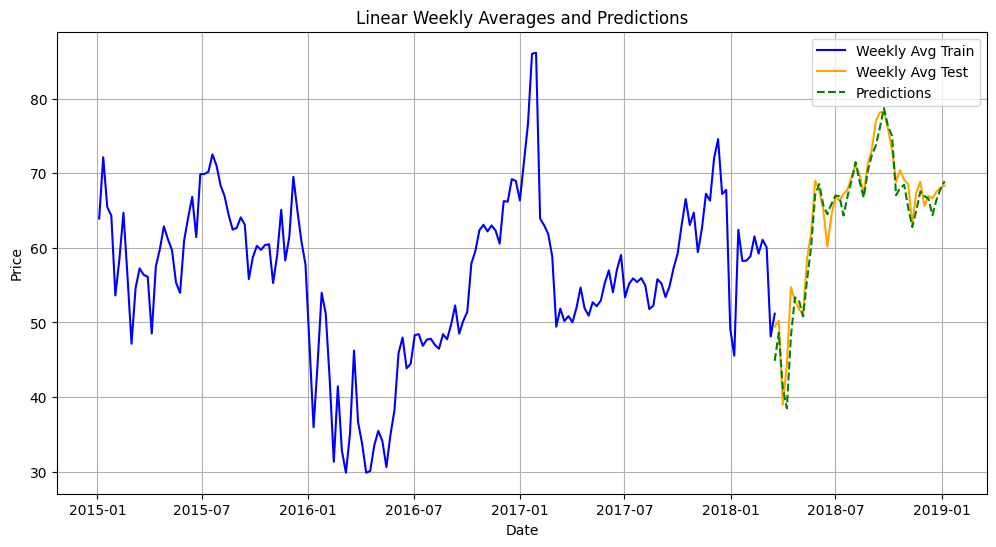

In [77]:
plot_model_preds(pca_data,"Linear")

To export in the PCA data in a more interpertable format with headers than arrays, it will be converted to a dataframe with timestamps and the response variable attached.

In [78]:
# Convert PCA-data to dataframe
columns = [f"Column {i+1}" for i in range(pca_data.X.shape[1])]
pca_data.X = pd.DataFrame(pca_data.X, columns=columns)

In [79]:
pca_data_df = pd.concat([ml_data.data["time"],pca_data.X,pca_data.y],axis=1)

In [80]:
len(pca_data_df) == len(ml_data.data)

True

In [81]:
#Export relevant files
ml_data.X_train.to_csv(r"engineered_data\feature_engineered_data_X_train.csv",index=False)
ml_data.X_train.to_parquet(r"engineered_data\feature_engineered_data_X_train.parquet",index=False)
pca_data_df.to_csv(r"engineered_data\pca_ml_ready_data.csv",index=False)
pca_data_df.to_parquet(r"engineered_data\pca_ml_ready_data.parquet",index=False)
#joblib.dump(pca_data,r"engineered_data\pca_ml_ready_data.pkl") #Keep floating point numbers

In [82]:
#save scaler and pca
joblib.dump(ml_data.scaler, "transformers/scaler.pkl")
joblib.dump(pca, "transformers/pca.pkl")

['transformers/pca.pkl']

In [83]:
ml_data.scaler

StandardScaler()

In [84]:
pca

PCA(n_components=0.95)